### Annual Rankings of Streamflow, SWE, ET, Soil Moisture, Precip (with anomalies)

This notebook will first build a linear regression between streamflow and SWE anomalies and compute the residual for these years and rank them. Then I will do the same for ranking years with annual ET signals, seasonal ET signals, winter, spring, and summer precip signals and fall soil moisture signals. Then I will look at how these years align with each other. 

This will cover the Water Years 1987 to 2020

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import datetime as dt

import rioxarray as rioxr
from rasterio.enums import Resampling
import geopandas as gpd 
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'

import seaborn as sns
import matplotlib.pyplot as plt
import xoak
import nctoolkit as nc
from dataretrieval import nwis
from scipy import stats


/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


nctoolkit is using Climate Data Operators version 2.1.0


In [2]:
# Polygon for Upper East River
upper_east_river_poly = gpd.read_file('../multisite/polygons/east_polygon.json')
upper_east_river_area = upper_east_river_poly.area # m^2

# East river full
east_taylor_polygon = gpd.read_file('../multisite/polygons/east_taylor.json')
east_river_poly = east_taylor_polygon[east_taylor_polygon["name"]=='East River']

### Pull in Snotel data and streamflow data

In [3]:
# Import snotel data
er_sntl_data = xr.open_dataset('/storage/dlhogan/sos/data/east_river_sntl_20220930.nc')

In [4]:
# normalized peak SWE
# create mean dataset for upper taylor (since 2011) and butte
butte_mean_ds = er_sntl_data.sel(Location=['Butte_380:CO:SNTL']).mean(dim='Location')
butte_mean_ds_filtered = butte_mean_ds.sel(Date=slice('1986-10-01', '2021-09-30'))
butte_mean_peak_swe = butte_mean_ds_filtered.WTEQ.groupby(butte_mean_ds_filtered.WY).max()
normalized_sntl_peak_swe = ((butte_mean_peak_swe - butte_mean_peak_swe.mean())/butte_mean_peak_swe.std()).to_dataframe()

# Butte 
butte_april_1_swe = butte_mean_ds_filtered.where((butte_mean_ds_filtered.Date.dt.month==4) & (butte_mean_ds_filtered.Date.dt.day==1)).WTEQ.to_dataframe().dropna()
butte_april_1_swe = butte_mean_ds_filtered.WTEQ.groupby(butte_mean_ds_filtered.WY).mean()
normalized_april_1_swe = ((butte_april_1_swe - butte_april_1_swe.mean())/butte_april_1_swe.std()).to_dataframe()

# Schofied
schofield_mean_ds = er_sntl_data.sel(Location=['SchofieldPass_737:CO:SNTL']).mean(dim='Location')
schofield_mean_ds_filtered = schofield_mean_ds.sel(Date=slice('1986-10-01', '2021-09-30'))
schofield_april_1_swe = schofield_mean_ds_filtered.where((schofield_mean_ds_filtered.Date.dt.month==4) & (schofield_mean_ds_filtered.Date.dt.day==1)).WTEQ.to_dataframe().dropna()
schofield_april_1_swe = schofield_april_1_swe.WTEQ.groupby(schofield_april_1_swe.WY).mean()
normalized_schofield_april_1_swe = ((schofield_april_1_swe - schofield_april_1_swe.mean())/schofield_april_1_swe.std())

In [5]:
butte_df = butte_mean_ds_filtered.WTEQ.to_dataframe()
butte_idx_max = butte_df['WTEQ'].groupby(butte_df.WY).idxmax()
butte_idx_max_doy= pd.to_datetime(butte_idx_max.values).dayofyear
butte_idx_max_df = pd.DataFrame(butte_idx_max_doy, index=butte_idx_max.index, columns=['peak_swe_doy'])
norm_butte_idx_max_df = (butte_idx_max_df-butte_idx_max_df.mean())/butte_idx_max_df.std()

In [6]:
er_usgs_almont = '09112500'

# get streamflow data from east river at almont
east_river_discharge_almont_dv = nwis.get_record(er_usgs_almont, start='1986-10-1', service='dv')['00060_Mean']

# Filter out until the end of our dataset
east_river_discharge_almont_dv = east_river_discharge_almont_dv.loc[:'2022-09-30']
# Filter out -9999 values
east_river_discharge_almont_dv = east_river_discharge_almont_dv[east_river_discharge_almont_dv>=0]

# Average to monthly values
east_river_discharge_almont_monthly = east_river_discharge_almont_dv.groupby(pd.Grouper(freq='M')).mean()
east_river_discharge_almont_monthly.index = pd.to_datetime(east_river_discharge_almont_monthly.index.date)

# Set index as datetime
east_river_discharge_almont_dv.index = pd.to_datetime(east_river_discharge_almont_dv.index).date
east_river_discharge_almont_dv.index = pd.to_datetime(east_river_discharge_almont_dv.index)

# Rename the series
east_river_discharge_almont_monthly.name = 'mean_discharge'
# Convert to dataframe and add in water year column
east_river_discharge_almont_monthly = east_river_discharge_almont_monthly.to_frame()
east_river_discharge_almont_monthly['WY'] = east_river_discharge_almont_monthly.index.year.where(east_river_discharge_almont_monthly.index.month < 10, east_river_discharge_almont_monthly.index.year + 1)

# create annual product
east_river_discharge_almont_annual = east_river_discharge_almont_monthly.groupby(east_river_discharge_almont_monthly['WY']).mean()
east_river_discharge_almont_annual_peak = east_river_discharge_almont_monthly.groupby(east_river_discharge_almont_monthly['WY']).max()

# create seasonal product 

# Wrap it into a simple function
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    month_length = ds.index.dt.days_in_month

    # Calculate the weighted average
    return (ds * month_length).resample(index='QS-JAN').sum() / month_length.resample(index='QS-JAN').sum()

east_river_discharge_almont_monthly_ds = east_river_discharge_almont_monthly.to_xarray()
east_river_discharge_almont_seasonal_ds = season_mean(east_river_discharge_almont_monthly_ds)
east_river_discharge_almont_seasonal_ds['WY'] = np.ceil(east_river_discharge_almont_seasonal_ds['WY'])
east_river_discharge_almont_spring_ds = east_river_discharge_almont_seasonal_ds.where(east_river_discharge_almont_seasonal_ds.index.dt.month==4)
east_river_discharge_almont_spring = east_river_discharge_almont_spring_ds.dropna(dim='index').to_pandas().set_index('WY')

In [7]:
# Function to get the day of Water Year
def date2DOWY(day_of_interest):
    day_of_interest = pd.to_datetime(day_of_interest)
    if day_of_interest >= dt.datetime(day_of_interest.year,10,1):
        dowy_start = dt.datetime(day_of_interest.year,10,1)
    else: 
        dowy_start = dt.datetime(day_of_interest.year-1,10,1)
    dowy = day_of_interest - dowy_start
    return dowy.days
dowy = np.zeros(len(east_river_discharge_almont_dv.index.values))
for i,date in enumerate(east_river_discharge_almont_dv.index.values):
    dowy[i] = date2DOWY(date)

In [8]:
east_river_discharge_almont_dv_dowy = pd.DataFrame(east_river_discharge_almont_dv)
east_river_discharge_almont_dv_dowy['dowy'] = dowy
east_river_discharge_almont_dv_dowy['WY'] = east_river_discharge_almont_dv_dowy.index.year.where(east_river_discharge_almont_dv_dowy.index.month < 10, east_river_discharge_almont_dv_dowy.index.year + 1)

In [9]:
com_date = {}
for year in east_river_discharge_almont_dv_dowy.WY:
    cumsum = east_river_discharge_almont_dv_dowy[east_river_discharge_almont_dv_dowy.WY == year].cumsum()
    com = (np.abs(cumsum['00060_Mean']-(cumsum['00060_Mean'].max()/2))).idxmin().day_of_year
    com_date[year] = com
center_of_mass_date = pd.Series(com_date)

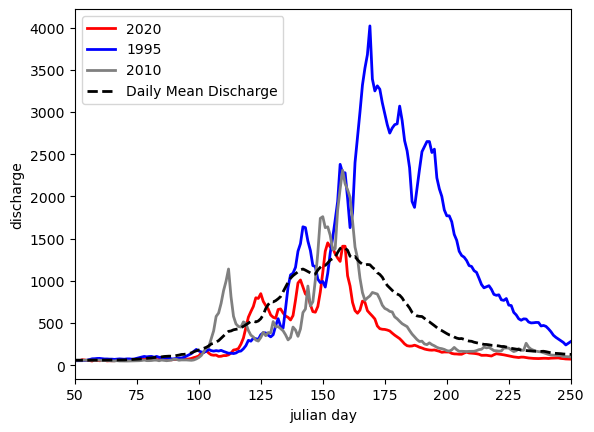

In [10]:
fig, ax = plt.subplots()
mean_daily_discharge = east_river_discharge_almont_dv.groupby(east_river_discharge_almont_dv.index.day_of_year).mean()
ax.plot(east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==2020].index.day_of_year,
        east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==2020], 
        color='red', 
        lw=2,
        label=2020)
ax.plot(east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==1995].index.day_of_year,
        east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==1995],
        color='blue',
        lw=2,
        label=1995)
ax.plot(east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==2010].index.day_of_year,
        east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==2010],
        color='grey', 
        lw=2,
        label=2010)
mean_daily_discharge.plot(color='k', ls='--',lw=2, label='Daily Mean Discharge')
ax.set_xlim(50,250)
ax.set_xlabel('julian day')
ax.set_ylabel('discharge')
ax.legend()

Text(0.5, 1.0, 'East River Cumulative Departure from Mean')

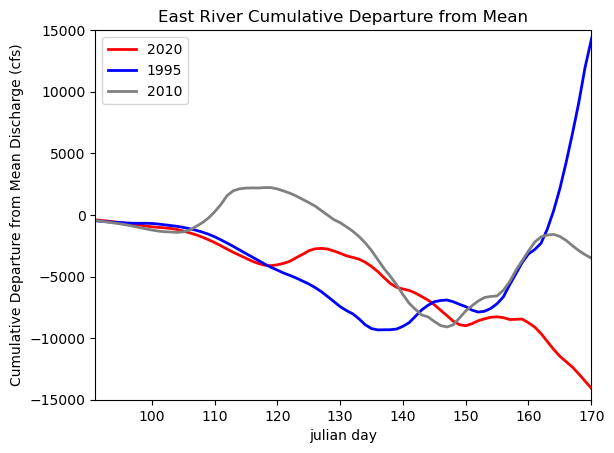

In [11]:
fig, ax = plt.subplots()
mean_daily_discharge = east_river_discharge_almont_dv.groupby(east_river_discharge_almont_dv.index.day_of_year).mean()

def cumulative_mean_diff(year):
        if (year % 4 != 0) & (year % 400 != 0):
                cum_mean_diff = (east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==year].values- mean_daily_discharge.drop(60).values).cumsum()
        else:
                cum_mean_diff = (east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==year].values-mean_daily_discharge.values).cumsum()
        return cum_mean_diff

ax.plot(east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==2020].index.day_of_year,
        cumulative_mean_diff(2020), 
        color='red', 
        lw=2,
        label=2020)
ax.plot(east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==1995].index.day_of_year,
        cumulative_mean_diff(1995), 
        color='blue', 
        lw=2,
        label=1995)
ax.plot(east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==2010].index.day_of_year,
        cumulative_mean_diff(2010), 
        color='grey', 
        lw=2,
        label=2010)

ax.set_xlim(91,170)
ax.set_ylim(-15000,15000)
ax.set_xlabel('julian day')
ax.set_ylabel('Cumulative Departure from Mean Discharge (cfs)')
ax.legend()
ax.set_title('East River Cumulative Departure from Mean')

In [12]:
# Create time frame of mean discharge from peak SWE to peak streamflow
peak_swe_peak_q = {}
peak_swe_peak_q_len = {}
for year in np.unique(butte_mean_ds_filtered.Date.dt.year.values):
    # if year not in [1986,2015]:
    if year not in [1986]:
        # Filter to each year
        tmp_swe = butte_mean_ds_filtered.where(butte_mean_ds_filtered.Date.dt.year==year)['WTEQ'].dropna(dim='Date')
        tmp_q =  east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==year]
        # calculate maximum swe date
        peak_swe_date = tmp_swe.idxmax().values
        peak_q_date = tmp_q.idxmax()

        # calculate mean over peak swe to peak q 
        tmp_q_filter = tmp_q.loc[peak_swe_date:peak_q_date]
        # add mean to dict
        peak_swe_peak_q[year] = tmp_q_filter.mean()
        peak_swe_peak_q_len[year] = len(tmp_q_filter)
       
peak_swe_peak_q_df = pd.Series(peak_swe_peak_q)
peak_swe_peak_q_len_df = pd.Series(peak_swe_peak_q_len)

In [13]:
# Create time frame of mean discharge from April 1 SWE to September 30 SWE
april_1_sep_30_q = {}

for year in np.unique(butte_mean_ds_filtered.Date.dt.year.values):
    if year not in [1986]:
        # Filter to each year
        tmp_q =  east_river_discharge_almont_dv[east_river_discharge_almont_dv.index.year==year]
        start = dt.date(year,4,1)
        end  = dt.date(year,9,30)

        # calculate mean over peak swe to peak q 
        tmp_q_filter = tmp_q.loc[start:end]
        # add mean to dict
        april_1_sep_30_q[year] = tmp_q_filter.mean()
       
april_1_sep_30_q_df = pd.Series(april_1_sep_30_q)

### Linear relationship between Streamflow and SWE

In [14]:
# normalized streamflow
normalized_er_spring_q = (east_river_discharge_almont_spring - east_river_discharge_almont_spring.mean())/ east_river_discharge_almont_spring.std()
normalized_er_annual_q = (east_river_discharge_almont_annual - east_river_discharge_almont_annual.mean())/ east_river_discharge_almont_annual.std()
normalized_er_peakswe_peak_q = (peak_swe_peak_q_df-peak_swe_peak_q_df.mean())/peak_swe_peak_q_df.std()
normalized_er_apr1_sep30_q = (april_1_sep_30_q_df-april_1_sep_30_q_df.mean())/april_1_sep_30_q_df.std()

In [15]:
basin_area = 7.485e8
cubic_ft_to_cubic_meters = 35.315
seconds_per_day = 3600 * 24
days = 6*30.5
apr1_sep30_mm = april_1_sep_30_q_df * seconds_per_day * days * 1000 / cubic_ft_to_cubic_meters / basin_area
butte_mean_peak_swe_mm = (butte_mean_peak_swe*10).to_pandas()

In [16]:
slope, intercept, rvalue, pvalue,stderr  = stats.linregress(butte_mean_peak_swe_mm, apr1_sep30_mm)#['mean_discharge'])

alpha = 0.05
c = (1 - alpha)

# Create regression line and residuals
X = butte_mean_peak_swe_mm.values
y_predicted = intercept + slope*X
residual = (apr1_sep30_mm-y_predicted)

# Setup 
n = X.size                                               
dof = n - 2
t = stats.t.ppf(c, dof) 

# sum of squared errors
sse = np.sum(residual**2)

# total sum of squares (y)
sst = np.sum( (apr1_sep30_mm - np.mean(apr1_sep30_mm))**2 )

# total sum of squares (x)
sst_x = np.sum( (X - np.mean(X))**2 )

# correlation coefficient
r_squared = 1 - sse/sst

# standard error of regression
s = np.sqrt(sse/(n-2))

# an array of x values
p_x = np.linspace(X.min(),X.max(),100)

# using our model parameters to predict y values
p_y = intercept + slope*p_x

# compute error of prediction for each p_x
sigma_ep = np.sqrt( s**2 * (1+ 1/n + ( ( n*(p_x-X.mean(axis=None))**2 ) / ( n*np.sum(X**2) - np.sum(X)**2 ) ) ) )
# set our confidence interval

p_y_lower = p_y - t * sigma_ep
p_y_upper = p_y + t * sigma_ep


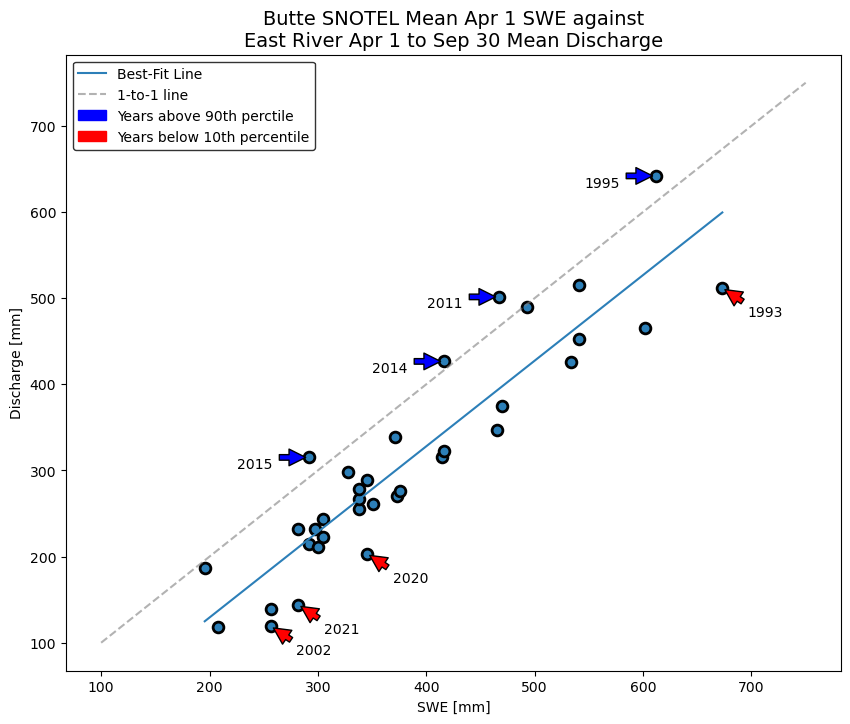

In [20]:
fig, ax = plt.subplots(ncols=1, figsize=(10,8))
colors = ['#2c7fb8','#7fcdbb']
residual=residual.dropna()
idx_20th_percentile = (residual[residual < np.percentile(residual,10)].index).astype(int)
idx_80th_percentile = (residual[residual > np.percentile(residual,90)].index).astype(int)

ax.scatter(butte_mean_peak_swe_mm, apr1_sep30_mm, color=colors[0], edgecolor='k', s=60, lw=2)
ax.plot([X.min(),X.max()], intercept+slope*np.array([X.min(),X.max()]), color=colors[0], label='Best-Fit Line')
ax.plot([100,750],[100,750], label='1-to-1 line', color='grey', ls='--', alpha=0.6)
# ax.plot(p_x, p_y_lower, color=colors[1], ls='--', label='Upper/Lower 90% Confidence Bound')
# ax.plot(p_x, p_y_upper, color=colors[1], ls='--', )
# ax.fill_between(p_x, p_y_lower,p_y_upper, color=colors[1], alpha=0.3)


for i,idx in enumerate(idx_20th_percentile):

    ax.annotate(str(idx), 
                    (butte_mean_peak_swe_mm.loc[idx], apr1_sep30_mm.loc[idx]),
                    (butte_mean_peak_swe_mm.loc[idx]+40, apr1_sep30_mm.loc[idx]-20),
                    arrowprops=dict(facecolor='red', shrink=0.1),
                    horizontalalignment='center', verticalalignment='top',)

for i,idx in enumerate(idx_80th_percentile):
    if idx == 2001:
        ax.annotate(str(idx), 
                (butte_mean_peak_swe_mm.loc[idx], apr1_sep30_mm.loc[idx]),
                (butte_mean_peak_swe_mm.loc[idx], apr1_sep30_mm.loc[idx]-40),
                arrowprops=dict(facecolor='blue', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)
        
    else:
        ax.annotate(str(idx), 
                (butte_mean_peak_swe_mm.loc[idx], apr1_sep30_mm.loc[idx]),
                (butte_mean_peak_swe_mm.loc[idx]-50, apr1_sep30_mm.loc[idx]),
                arrowprops=dict(facecolor='blue', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)

ax.arrow([],[],[],[], color='blue', label='Years above 90th perctile',width=0.1)
ax.arrow([],[],[],[], color='red', label='Years below 10th percentile',width=0.1)
ax.set_xlabel('SWE [mm]')
ax.set_ylabel('Discharge [mm]')
ax.set_title('Butte SNOTEL Mean Apr 1 SWE against\nEast River Apr 1 to Sep 30 Mean Discharge', size=14)
ax.legend(edgecolor='k', facecolor='white')

In [17]:
slope, intercept, rvalue, pvalue,stderr  = stats.linregress(normalized_schofield_april_1_swe, normalized_er_apr1_sep30_q)#['mean_discharge'])

alpha = 0.05
c = (1 - alpha)

# Create regression line and residuals
X = normalized_schofield_april_1_swe
y_predicted = intercept + slope*X
residual_schofield = (normalized_er_apr1_sep30_q-y_predicted)

# Setup 
n = X.size                                               
dof = n - 2
t = stats.t.ppf(c, dof) 

# sum of squared errors
sse = np.sum(residual**2)

# total sum of squares (y)
sst = np.sum( (normalized_er_apr1_sep30_q - np.mean(normalized_er_apr1_sep30_q))**2 )

# total sum of squares (x)
sst_x = np.sum( (X - np.mean(X))**2 )

# correlation coefficient
r_squared = 1 - sse/sst

# standard error of regression
s = np.sqrt(sse/(n-2))

# an array of x values
p_x = np.linspace(X.min(),X.max(),100)

# using our model parameters to predict y values
p_y = intercept + slope*p_x

# compute error of prediction for each p_x
sigma_ep = np.sqrt( s**2 * (1+ 1/n + ( ( n*(p_x-X.mean(axis=None))**2 ) / ( n*np.sum(X**2) - np.sum(X)**2 ) ) ) )
# set our confidence interval

p_y_lower = p_y - t * sigma_ep
p_y_upper = p_y + t * sigma_ep


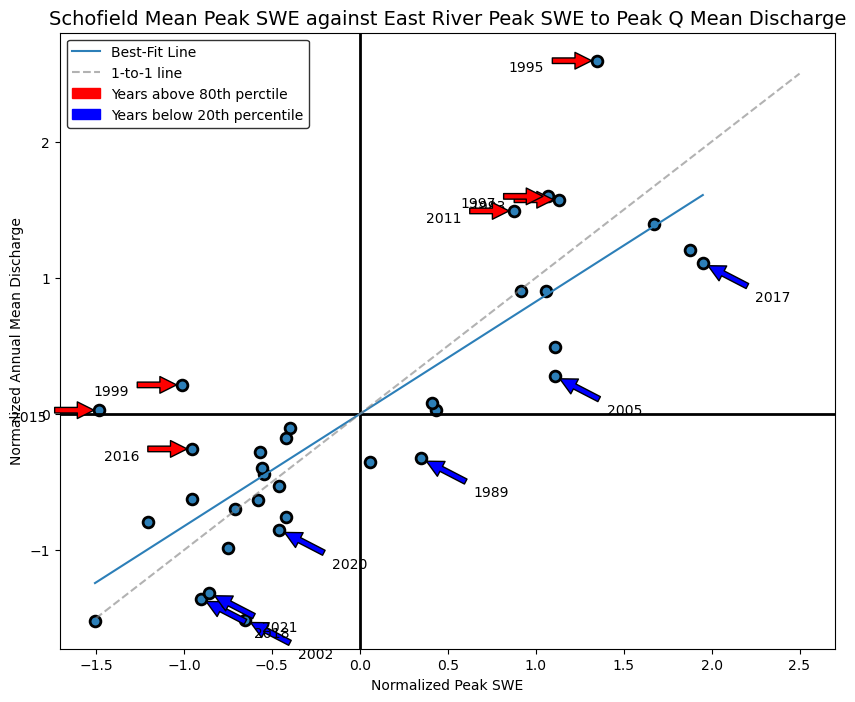

In [18]:
fig, ax = plt.subplots(ncols=1, figsize=(10,8))
colors = ['#2c7fb8','#7fcdbb']
idx_20th_percentile = (residual_schofield[residual_schofield < np.percentile(residual_schofield,20)].index).astype(int)
idx_80th_percentile = (residual_schofield[residual_schofield > np.percentile(residual_schofield,80)].index).astype(int)

ax.scatter(normalized_schofield_april_1_swe, normalized_er_apr1_sep30_q, color=colors[0], edgecolor='k', s=60, lw=2)
ax.axhline(0, color='k', lw=2)
ax.axvline(0, color='k', lw=2)
ax.plot([X.min(),X.max()], intercept+slope*np.array([X.min(),X.max()]), color=colors[0], label='Best-Fit Line')
ax.plot([-1.5,2.5],[-1.5,2.5], label='1-to-1 line', color='grey', ls='--', alpha=0.6)
# ax.plot(p_x, p_y_lower, color=colors[1], ls='--', label='Upper/Lower 90% Confidence Bound')
# ax.plot(p_x, p_y_upper, color=colors[1], ls='--', )
# ax.fill_between(p_x, p_y_lower,p_y_upper, color=colors[1], alpha=0.3)


for i,idx in enumerate(idx_20th_percentile):

    ax.annotate(str(idx), 
                    (normalized_schofield_april_1_swe.loc[idx], normalized_er_apr1_sep30_q.loc[idx]),
                    (normalized_schofield_april_1_swe.loc[idx]+0.4, normalized_er_apr1_sep30_q.loc[idx]-0.2),
                    arrowprops=dict(facecolor='blue', shrink=0.1),
                    horizontalalignment='center', verticalalignment='top',)

for i,idx in enumerate(idx_80th_percentile):
    if idx == 2001:
        ax.annotate(str(idx), 
                (normalized_schofield_april_1_swe.loc[idx], normalized_er_apr1_sep30_q.loc[idx]),
                (normalized_schofield_april_1_swe.loc[idx], normalized_er_apr1_sep30_q.loc[idx]-0.4),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)
        
    else:
        ax.annotate(str(idx), 
                (normalized_schofield_april_1_swe.loc[idx], normalized_er_apr1_sep30_q.loc[idx]),
                (normalized_schofield_april_1_swe.loc[idx]-0.4, normalized_er_apr1_sep30_q.loc[idx]),
                arrowprops=dict(facecolor='red', shrink=0.1),
                horizontalalignment='center', verticalalignment='top',)

ax.arrow([],[],[],[], color='red', label='Years above 80th perctile',width=0.1)
ax.arrow([],[],[],[], color='blue', label='Years below 20th percentile',width=0.1)
ax.set_xlabel('Normalized Peak SWE')
ax.set_ylabel('Normalized Annual Mean Discharge')
ax.set_title('Schofield Mean Peak SWE against East River Peak SWE to Peak Q Mean Discharge', size=14)
ax.legend(edgecolor='k', facecolor='white')

In [19]:
sorted_residual = residual.sort_values()

### Residual vs flow center of mass

Text(0, 0.5, 'SWE - Q Residual')

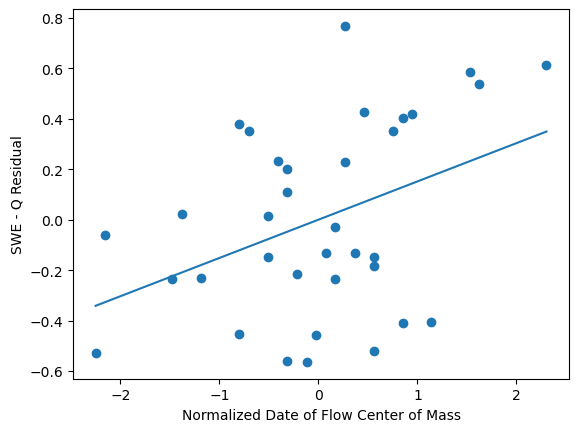

In [20]:
norm_com = (center_of_mass_date-center_of_mass_date.mean())/center_of_mass_date.std()
slope, intercept, rvalue, pvalue,stderr  = stats.linregress(norm_com, residual)#['mean_discharge'])
plt.scatter(norm_com,residual)
plt.plot([norm_com.min(),norm_com.max()], slope*np.array([norm_com.min(),norm_com.max()]+intercept))
plt.xlabel('Normalized Date of Flow Center of Mass')
plt.ylabel('SWE - Q Residual')


### Calculate snow melt season length and sort by years

In [21]:
# melt season length dictionary
melt_season_length_dict = {}
snow_melt_date_dict = {}

# iterate through each year to calculate the WY melt season length
for year in np.unique(butte_mean_ds_filtered.Date.dt.year.values):
    # if year not in [1986,2015]:
    if year not in [1986]:
        # Filter to each year
        tmp = butte_mean_ds_filtered.where(butte_mean_ds_filtered.Date.dt.year==year)['WTEQ'].dropna(dim='Date')
        # calculate maximum swe date
        peak_swe_date = tmp.idxmax().values
        # calculate peak swe value
        peak_swe = tmp.max()
        # calculate weekly rolling average
        weekly_rolling_mean = tmp.rolling(Date=7).mean()
        # first date where rolling weekly average is < 5% of Peak SWE  is considered snow melt date
        snow_melt_date = weekly_rolling_mean.where(weekly_rolling_mean==0).dropna(dim='Date')[0].Date.values
        # difference in time between peak and melt is snow melt season length
        melt_season_length = (snow_melt_date - peak_swe_date).astype('timedelta64[D]').astype(np.int32)
        # add to disctionary
        melt_season_length_dict[year] = melt_season_length
        snow_melt_date_dict[year] = pd.Timestamp(snow_melt_date).day_of_year
# create series of melt season length
melt_season_len_days = pd.Series(melt_season_length_dict.values(), index = melt_season_length_dict.keys(), name='melt_season_length')
sdd = pd.Series(snow_melt_date_dict.values(), index = snow_melt_date_dict.keys(), name='snow_dissapearance_date')
norm_melt_season_len = (melt_season_len_days - melt_season_len_days.mean())/melt_season_len_days.std()
norm_sdd = (sdd - sdd.mean())/sdd.std()

In [22]:
norm_melt_season_sorted = norm_melt_season_len.sort_values()

In [23]:
# Spearman rank coefficent for melt season length
stats.spearmanr(norm_melt_season_sorted.index, sorted_residual.index)

SignificanceResult(statistic=0.11792717086834735, pvalue=0.4998731314451449)

In [24]:
# Spearman rank coefficent for snow disappearance date
stats.spearmanr(norm_sdd.sort_values().index, sorted_residual.index)

SignificanceResult(statistic=-0.12128851540616246, pvalue=0.4876433348131164)

Text(0.5, 0.98, 'Butte')

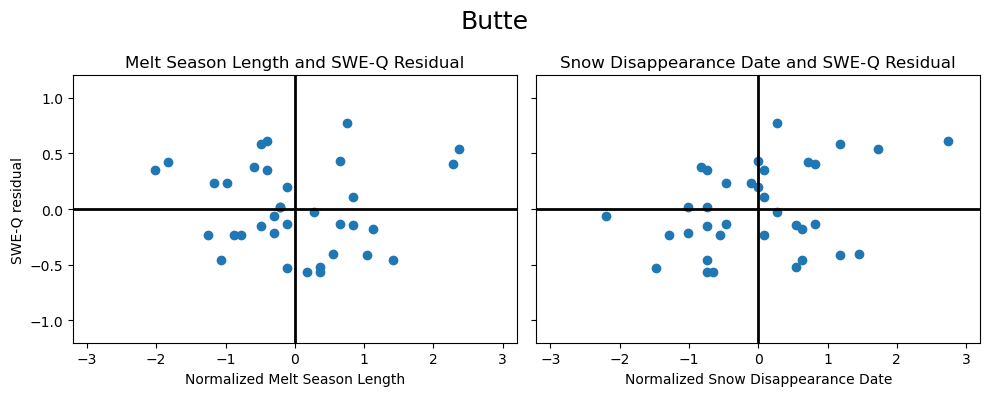

In [25]:
fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10,4), sharey=True)

axs[0].scatter(norm_melt_season_len.values,residual.values)
axs[0].set_xlabel('Normalized Melt Season Length')
axs[0].set_ylabel('SWE-Q residual')
axs[0].axhline(0, color='k', lw=2)
axs[0].axvline(0, color='k', lw=2)
axs[0].set_xlim(-3.2,3.2)
axs[0].set_ylim(-1.2,1.2)
axs[0].set_title('Melt Season Length and SWE-Q Residual', size=12)

axs[1].scatter(norm_sdd.values,residual.values)
axs[1].set_xlabel('Normalized Snow Disappearance Date')
axs[1].axhline(0, color='k', lw=2)
axs[1].axvline(0, color='k', lw=2)
axs[1].set_xlim(-3.2,3.2)
axs[1].set_ylim(-1.2,1.2)
axs[1].set_title('Snow Disappearance Date and SWE-Q Residual', size=12)

fig.suptitle('Butte', size=18)

This does not really tell me much about the relationship between melt season length and the SWE-Q residual. A relationship does not seem to appear. Why might this be? It does not tell me anything about the timing of snow dissappearance. Perhaps snow disappearance date is more what I want. A shorter melt season would be expected to have to counteracting situations: 
1) signifies a warmer period during spring which could start up ET a bit earlier and remove more water, especially if the antecedent soil moisture was low
2) signifies rapid melt out, which may both saturate the soils and lead to overland flow, causing increased SWE-Q relationship

2015 had less than average snowfall, but greater than average streamflow, why might this be? Snowmelt season was rather drawn out and was well above average in length. Was it cold over this period? How much rain in spring was there? How strong was the monsoon? How saturated were soils in the fall?

### Calculate Max SWE signals in first 60 days of the WY

Text(0.5, 1.0, 'Norm Sum of Oct/Nov SWE and SWE-Q Residual')

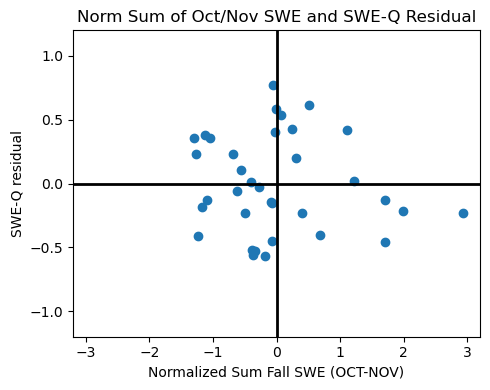

In [26]:
butte_fall_swe = butte_mean_ds_filtered.where(butte_mean_ds_filtered.Date.dt.month.isin([10,11]))
butte_fall_max_swe = butte_fall_swe.WTEQ.groupby("WY").sum().to_dataframe()
norm_max_fall_swe = (butte_fall_max_swe - butte_fall_max_swe.mean())/butte_fall_max_swe.std()

fig, ax = plt.subplots(ncols=1, tight_layout=True, figsize=(5,4), sharey=True)

ax.scatter(norm_max_fall_swe.values,residual.values)
ax.set_xlabel('Normalized Sum Fall SWE (OCT-NOV)')
ax.set_ylabel('SWE-Q residual')
ax.axhline(0, color='k', lw=2)
ax.axvline(0, color='k', lw=2)
ax.set_xlim(-3.2,3.2)
ax.set_ylim(-1.2,1.2)
ax.set_title('Norm Sum of Oct/Nov SWE and SWE-Q Residual', size=12)

# Remaining Things to Look at
- Signals for basin wide fall soil moisture
- Signals from fall, winter, and spring ET
- Signals from fall, winter, and spring SWE/Precip?
- Snow dissapearnce date

### Signals of Annual Precipitation

In [27]:
wrf_climatology_ds = xr.open_dataset('/storage/dlhogan/sos/data/wrf_climatology_precip.nc')

In [28]:
wrf_climatology_precip = wrf_climatology_ds.where(wrf_climatology_ds['EAST_MASK']==True)['precip'].mean(dim=['south_north','west_east']).to_dataframe()
wrf_annual_precip = wrf_climatology_precip.groupby(wrf_climatology_precip['WY']).sum()
norm_wrf_annual_precip = (wrf_annual_precip-wrf_annual_precip.mean())/wrf_annual_precip.std()

sorted_annual_precip = norm_wrf_annual_precip.sort_values(by='precip')
sorted_annual_precip_top_5 = sorted_annual_precip[:5].index.values


### Signals of Seasonal Precipiation

In [29]:
def season_mean_df(df, calendar="standard", column=None):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    df['month_length'] = df.index.days_in_month
    # Calculate the weighted average
    return (df[column]* df['month_length']).resample('Q-NOV', convention='end').agg('sum') / df['month_length'].resample('Q-NOV', convention='end').agg('sum')

In [30]:
stand_anomalies_precip_seasonal_df  = season_mean_df(wrf_climatology_precip, column='precip').to_frame(name='precip')
norm_anomalies_precip_seasonal_df = stand_anomalies_precip_seasonal_df.groupby(stand_anomalies_precip_seasonal_df.index.month).transform(lambda x: (x-x.mean())/x.std())
norm_anomalies_precip_seasonal_df.index = pd.to_datetime(norm_anomalies_precip_seasonal_df.index)
norm_anomalies_precip_seasonal_df['WY']=norm_anomalies_precip_seasonal_df.index.year.where(norm_anomalies_precip_seasonal_df.index.month<10,norm_anomalies_precip_seasonal_df.index.year+1)

In [31]:
sorted_summer_precip = norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==8]
sorted_summer_precip_top_5 = sorted_summer_precip.sort_values(by='precip')[:5]['WY'].values

sorted_fall_precip = norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==11]
sorted_fall_precip_top_5 = sorted_fall_precip.sort_values(by='precip')[:5]['WY'].values

sorted_winter_precip = norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==2]
sorted_winter_precip_top_5 = sorted_winter_precip.sort_values(by='precip')[:5]['WY'].values

sorted_spring_precip = norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==5]
sorted_spring_precip_top_5 = sorted_spring_precip.sort_values(by='precip')[:5]['WY'].values

In [32]:
# Spearman rank coefficent for seasonal ET
print(stats.spearmanr(sorted_summer_precip.sort_values(by='precip').WY, sorted_residual.index[:-1]))
print(stats.spearmanr(sorted_spring_precip.sort_values(by='precip').WY, sorted_residual.index[:-1]))
print(stats.spearmanr(sorted_winter_precip.sort_values(by='precip').WY, sorted_residual.index[:-1]))
print(stats.spearmanr(sorted_summer_precip.sort_values(by='precip').WY, sorted_residual.index[:-1]))

SignificanceResult(statistic=-0.04323911382734912, pvalue=0.8081540967203267)
SignificanceResult(statistic=-0.04079449961802903, pvalue=0.8188156166976333)
SignificanceResult(statistic=-0.0505729564553094, pvalue=0.7763796386758828)
SignificanceResult(statistic=-0.04323911382734912, pvalue=0.8081540967203267)


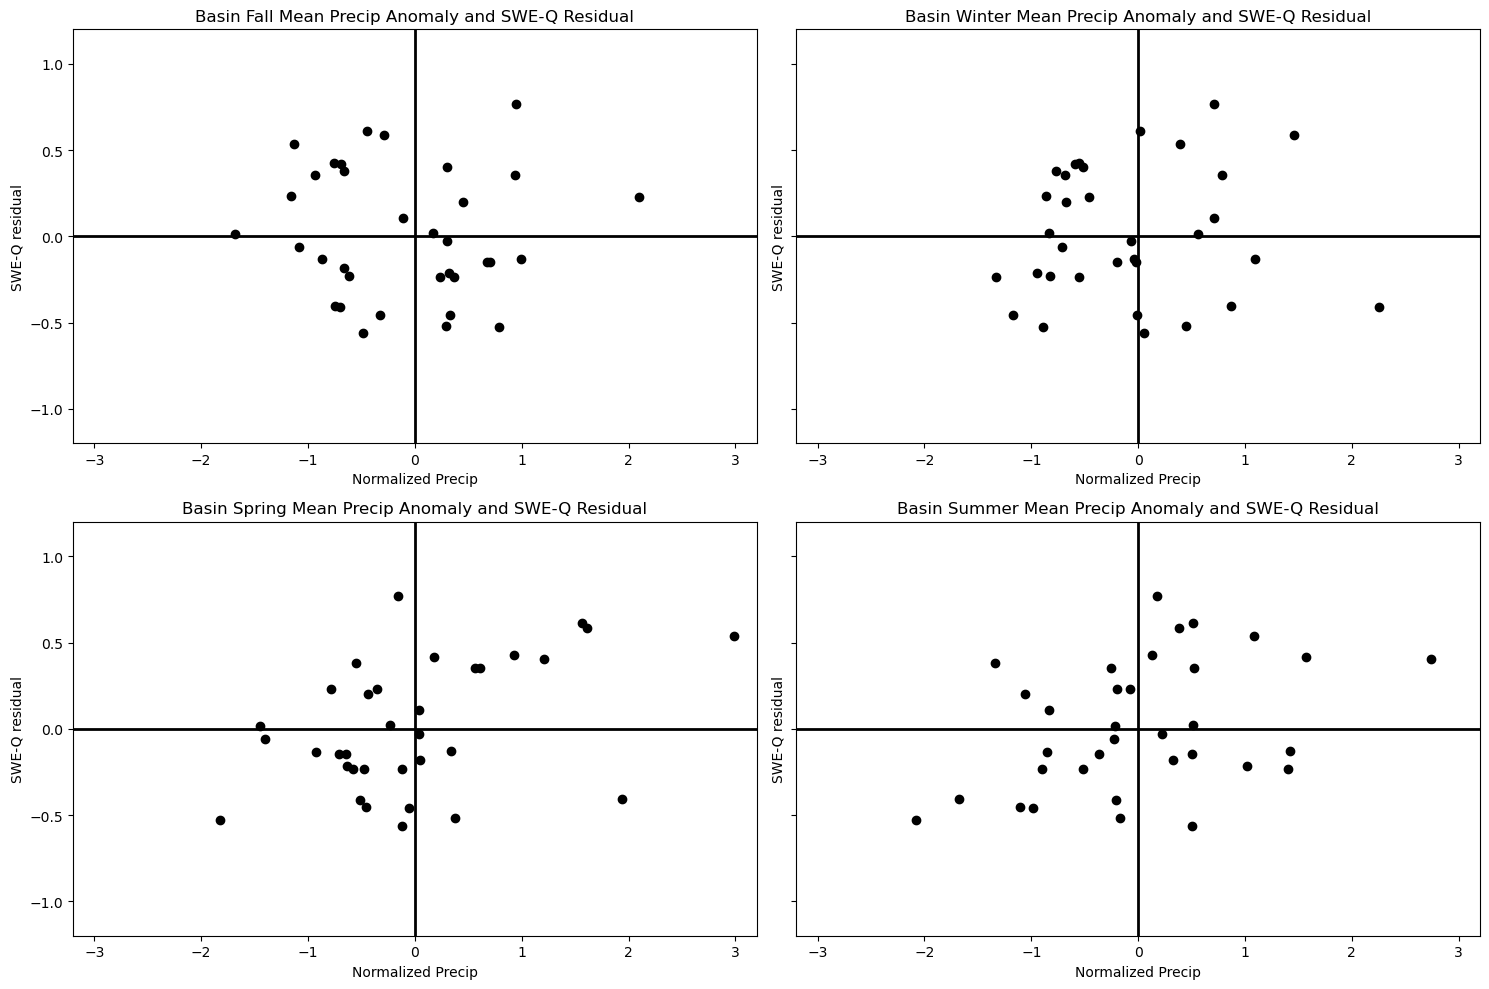

In [33]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, sharey=True, figsize=(15,10))

axs = axs.ravel()
seasons = {
    'Fall':sorted_fall_precip['precip'].iloc[1:],
    'Winter':sorted_winter_precip['precip'],
    'Spring':sorted_spring_precip['precip'],
    'Summer':sorted_summer_precip['precip']
}

for i,ax in enumerate(axs):
    season = list(seasons.keys())[i]
    ax.scatter(list(seasons.values())[i],residual.iloc[:-1], color='k')
    ax.set_title(f'Basin {season} Mean Precip Anomaly and SWE-Q Residual')
    ax.set_ylabel('SWE-Q residual')
    ax.set_xlabel(f'Normalized Precip')
    ax.axhline(0, color='k', lw=2)
    ax.axvline(0, color='k', lw=2)
    ax.set_xlim(-3.2,3.2)
    ax.set_ylim(-1.2,1.2)

### Signals of Upper East River Basin Wide Fall Soil Moisture

In [34]:
cbrfc_sm = rioxr.open_rasterio('/storage/dlhogan/sos/data/cbrfc_fall_soil_product.nc')
cbrfc_sm = cbrfc_sm.rio.set_crs('EPSG:4326')
cbrfc_sm_rpj = cbrfc_sm.rio.reproject(east_river_poly.crs, resampling=Resampling.cubic)
er_cbrfc_sm_rpj = cbrfc_sm_rpj.rio.clip(east_river_poly.geometry)

<AxesSubplot: title={'center': 'year = 2.019e+03, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

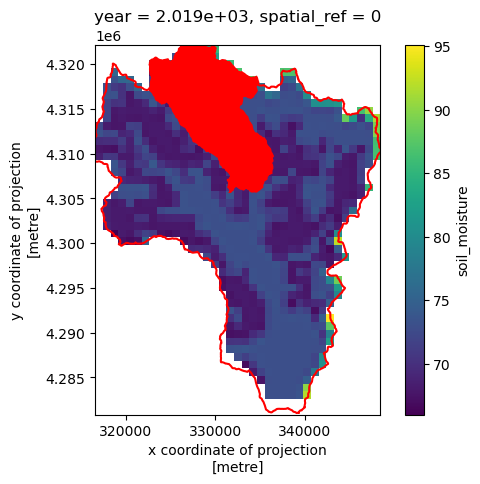

In [35]:
fig, ax = plt.subplots()
er_cbrfc_sm_rpj.sel(year=2019).plot(ax=ax)
east_river_poly.boundary.plot(ax=ax, color='red')
upper_east_river_poly.plot(ax=ax, color='red')

In [36]:
# Normalized anomaly of basin mean fall soil moisture percent from normal
er_cbrfc_sm_rpj_basin_mean = er_cbrfc_sm_rpj.sel(year=slice(1986,2020)).mean(dim='x').mean(dim='y')
norm_er_cbrfc_rpj_basin_mean = (er_cbrfc_sm_rpj_basin_mean-er_cbrfc_sm_rpj_basin_mean.mean())/er_cbrfc_sm_rpj_basin_mean.std()

In [37]:
# Spearman rank coefficent for snow disappearance date
stats.spearmanr(norm_er_cbrfc_rpj_basin_mean.to_dataframe()['soil_moisture'].index, sorted_residual.index)

SignificanceResult(statistic=-0.09635854341736695, pvalue=0.5818766113490357)

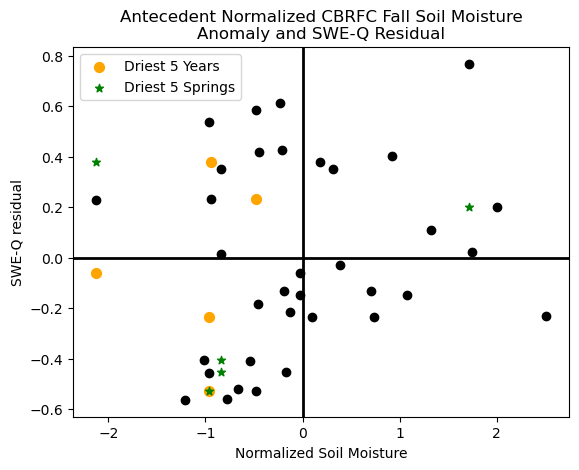

In [38]:
plt.scatter(norm_er_cbrfc_rpj_basin_mean,residual, color='k')
plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_annual_precip_top_5],residual.loc[sorted_annual_precip_top_5], color='orange',s=50,label='Driest 5 Years')
# plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_summer_precip_top_5],residual.loc[sorted_summer_precip_top_5], color='r', s=30, label='Driest 5 Summers')
# plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_fall_precip_top_5],residual.loc[sorted_fall_precip_top_5], color='orange', s=30, label='Driest 5 Falls')
# plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_winter_precip_top_5],residual.loc[sorted_summer_precip_top_5], color='b', s=30, label='Driest 5 Winters')
plt.scatter(norm_er_cbrfc_rpj_basin_mean.loc[sorted_spring_precip_top_5],residual.loc[sorted_summer_precip_top_5], color='g',s=35,label='Driest 5 Springs', marker='*')


plt.title('Antecedent Normalized CBRFC Fall Soil Moisture\nAnomaly and SWE-Q Residual')
plt.ylabel('SWE-Q residual')
plt.xlabel('Normalized Soil Moisture')
plt.axhline(0, color='k', lw=2)
plt.axvline(0, color='k', lw=2)
plt.legend()

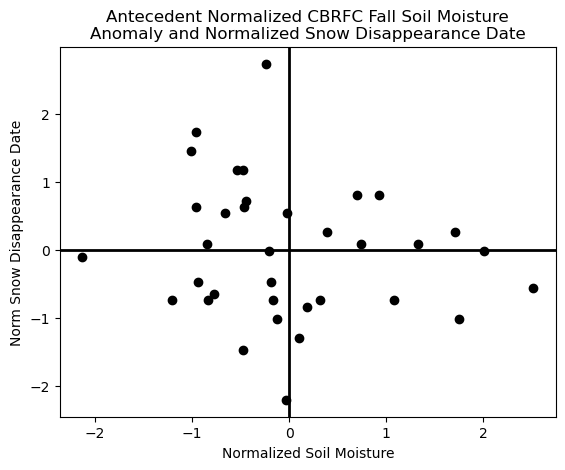

In [39]:
plt.scatter(norm_er_cbrfc_rpj_basin_mean,norm_sdd, color='k')

plt.title('Antecedent Normalized CBRFC Fall Soil Moisture\nAnomaly and Normalized Snow Disappearance Date')
plt.ylabel('Norm Snow Disappearance Date')
plt.xlabel('Normalized Soil Moisture')
plt.axhline(0, color='k', lw=2)
plt.axvline(0, color='k', lw=2)

### Pull in MERRA-2 Data

In [40]:
# ds = xr.open_mfdataset('/storage/dlhogan/sos/data/merra_2/*.nc4', engine='netcdf4')
# # Get the centroid of the East River basin in order to filter on this 
# centroid = east_river_poly.centroid

# # Add a CRS and reproject
# ds = ds.rio.write_crs('EPSG:4326')
# ds = ds.rio.set_spatial_dims(x_dim='lon',y_dim='lat')
# merra2_sm_rpj = ds.rio.reproject(east_river_poly.crs, resampling=Resampling.cubic)

# # Filter to the centroid of the east river, this will give me one overlapping data point.
# er_merra2_sm_rpj = merra2_sm_rpj.sel(x = centroid.x[0], method='nearest').sel(y = centroid.y[0], method='nearest')
# er_merra2_sm_rpj = er_merra2_sm_rpj.sel(time=slice('1985-10-1','2020-09-30'))

In [41]:
# # Quick visualization of what this looks like
# fig, ax = plt.subplots()
# merra2_sm_rpj.isel(time=1)['GWETROOT'].plot.imshow(ax=ax)
# ax.scatter(er_merra2_sm_rpj.x,er_merra2_sm_rpj.y, s=1000, color='r')
# upper_east_river_poly.plot(ax=ax)

In [42]:
# # Build the monthly anomaly dataset
# norm_merra2_er_sm = xr.apply_ufunc(
#     lambda x, mean,std: (x - mean)/std, 
#     er_merra2_sm_rpj['GWETROOT'].groupby('time.month'),
#     er_merra2_sm_rpj['GWETROOT'].groupby('time.month').mean(),
#     er_merra2_sm_rpj['GWETROOT'].groupby('time.month').std(),
#     dask='parallelized'
# ).drop('month').to_dataframe()
# norm_merra2_er_sm.index = norm_merra2_er_sm.index.date
# norm_merra2_er_sm.index = pd.to_datetime(norm_merra2_er_sm.index)
# norm_merra2_er_sm['WY']=norm_merra2_er_sm.index.year.where(norm_merra2_er_sm.index.month<10,norm_merra2_er_sm.index.year+1)

In [43]:
# test_df = season_mean_df(norm_merra2_er_sm, column='GWETROOT').to_frame(name='GWETROOT')
# test_2_df = test_df.groupby(test_df.index.month).transform(lambda x: (x-x.mean())/x.std())

In [44]:
# # Compile into seasonal anomalies of soil moisture
# er_merra2_sm_seasonal_df = season_mean_df(er_merra2_sm_rpj.to_dataframe(), column='GWETROOT').to_frame(name='GWETROOT')
# norm_er_merra2_sm_seasonal_df = er_merra2_sm_seasonal_df.groupby(er_merra2_sm_seasonal_df.index.month).transform(lambda x: (x-x.mean())/x.std()).interpolate(method='linear') #interpolate missing years
# norm_er_merra2_sm_seasonal_df.index = pd.to_datetime(norm_er_merra2_sm_seasonal_df.index)
# norm_er_merra2_sm_seasonal_df['WY']=norm_er_merra2_sm_seasonal_df.index.year.where(norm_er_merra2_sm_seasonal_df.index.month<10,norm_er_merra2_sm_seasonal_df.index.year+1)
# norm_er_merra2_sm_seasonal_df['GWETROOT'].plot()

In [45]:
# # Compare how different seasonal means correlate to SWE-Q

# fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, sharey=True, figsize=(12,10))

# axs = axs.ravel()
# seasons = {
#     'Fall':norm_er_merra2_sm_seasonal_df[norm_er_merra2_sm_seasonal_df.index.month==9]['GWETROOT'],
#     'Winter':norm_er_merra2_sm_seasonal_df[norm_er_merra2_sm_seasonal_df.index.month==12]['GWETROOT'],
#     'Spring':norm_er_merra2_sm_seasonal_df[norm_er_merra2_sm_seasonal_df.index.month==3]['GWETROOT'],
#     'Summer':norm_er_merra2_sm_seasonal_df[norm_er_merra2_sm_seasonal_df.index.month==6]['GWETROOT']
# }

# for i,ax in enumerate(axs):
#     ax.scatter(list(seasons.values())[i],residual, color='k')
#     ax.set_title(f'Basin {list(seasons.keys())[i]} Mean MERRA-2 Soil Moisture Anomaly\nand SWE-Q Residual')
#     ax.set_ylabel('SWE-Q residual')
#     ax.set_xlabel(f'Normalized MERRA-2 Soil Moisture')
#     ax.axhline(0, color='k', lw=2)
#     ax.axvline(0, color='k', lw=2)
#     ax.set_xlim(-3.2,3.2)
#     ax.set_ylim(-1.2,1.2)

### Signals of Annual ET

In [46]:
wrf_climatology_et = wrf_climatology_ds.where(wrf_climatology_ds['EAST_MASK']==True)['ET_rate'].mean(dim=['south_north','west_east']).to_dataframe()
wrf_annual_et = wrf_climatology_et.groupby(wrf_climatology_et['WY']).sum()
norm_wrf_annual_et = (wrf_annual_et-wrf_annual_et.mean())/wrf_annual_et.std()

sorted_annual_et = norm_wrf_annual_et.sort_values(by='ET_rate')
sorted_annual_et_top_5 = sorted_annual_et[-5:].index.values


In [47]:
# Spearman rank coefficent for snow disappearance date
stats.spearmanr(sorted_annual_et.index, sorted_residual[sorted_residual.index!=2021].index)

SignificanceResult(statistic=0.058823529411764705, pvalue=0.7410569990631823)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


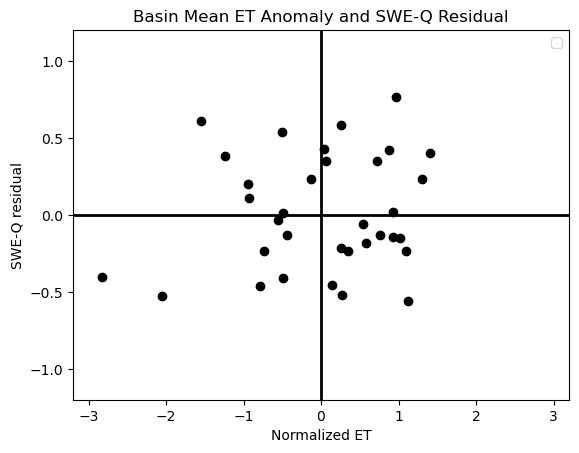

In [48]:
plt.scatter(norm_wrf_annual_et,residual.iloc[:-1], color='k')

plt.title('Basin Mean ET Anomaly and SWE-Q Residual')
plt.ylabel('SWE-Q residual')
plt.xlabel('Normalized ET')
plt.axhline(0, color='k', lw=2)
plt.axvline(0, color='k', lw=2)
plt.xlim(-3.2, 3.2)
plt.ylim(-1.2,1.2)
plt.legend()

(-3.2, 3.2)

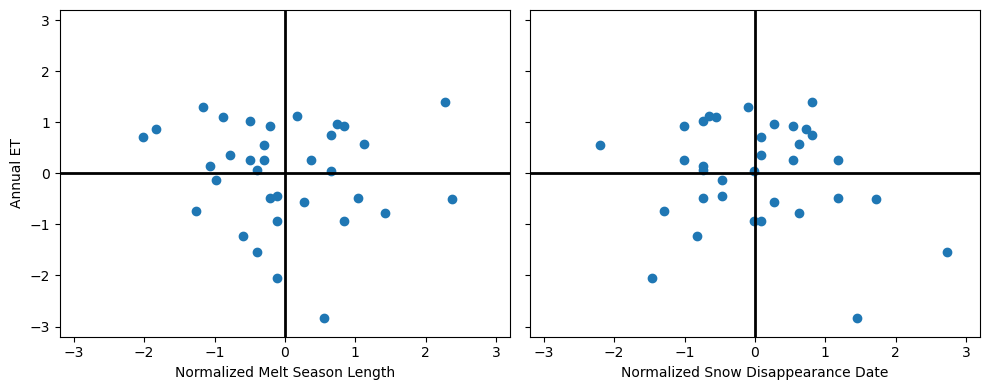

In [49]:

fig, axs = plt.subplots(ncols=2, tight_layout=True, figsize=(10,4), sharey=True)

axs[0].scatter(norm_melt_season_len[norm_melt_season_len.index!=2021].values,norm_wrf_annual_et.values)
axs[0].set_xlabel('Normalized Melt Season Length')
axs[0].set_ylabel('Annual ET')
axs[0].axhline(0, color='k', lw=2)
axs[0].axvline(0, color='k', lw=2)
axs[0].set_xlim(-3.2,3.2)
axs[0].set_ylim(-3.2,3.2)

axs[1].scatter(norm_sdd[norm_sdd.index!=2021].values,norm_wrf_annual_et.values)
axs[1].set_xlabel('Normalized Snow Disappearance Date')
axs[1].axhline(0, color='k', lw=2)
axs[1].axvline(0, color='k', lw=2)
axs[1].set_xlim(-3.2,3.2)
axs[1].set_ylim(-3.2,3.2)

### Signals of Season Sublimation/Evaporation

In [50]:
stand_anomalies_et_seasonal_df  = season_mean_df(wrf_climatology_et, column='ET_rate').to_frame(name='ET_rate')
norm_anomalies_et_seasonal_df = stand_anomalies_et_seasonal_df.groupby(stand_anomalies_et_seasonal_df.index.month).transform(lambda x: (x-x.mean())/x.std())
norm_anomalies_et_seasonal_df.index = pd.to_datetime(norm_anomalies_et_seasonal_df.index)
norm_anomalies_et_seasonal_df['WY']=norm_anomalies_et_seasonal_df.index.year.where(norm_anomalies_et_seasonal_df.index.month<10,norm_anomalies_et_seasonal_df.index.year+1)

In [51]:
# Spearman rank coefficent for seasonal ET
print(stats.spearmanr(norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==11].sort_values(by='ET_rate').WY, sorted_residual.index))
print(stats.spearmanr(norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==2].sort_values(by='ET_rate').WY, sorted_residual.index[sorted_residual.index!=2021]))
print(stats.spearmanr(norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==5].sort_values(by='ET_rate').WY, sorted_residual.index[sorted_residual.index!=2021]))
print(stats.spearmanr(norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==8].sort_values(by='ET_rate').WY, sorted_residual.index[sorted_residual.index!=2021]))

SignificanceResult(statistic=0.04397759103641457, pvalue=0.8019321429849491)
SignificanceResult(statistic=-0.31734148204736434, pvalue=0.06743190500237967)
SignificanceResult(statistic=0.009625668449197862, pvalue=0.9569123892854601)
SignificanceResult(statistic=-0.030710466004583648, pvalue=0.8631123148395858)


Text(0, 0.5, 'Normalized Basin Mean ET')

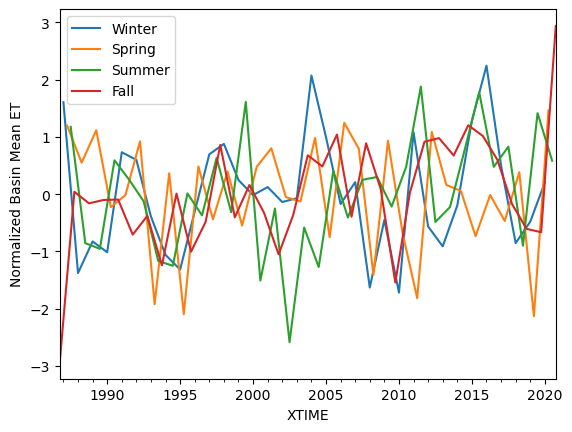

In [52]:
norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==2]['ET_rate'].plot(label='Winter')
norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==5]['ET_rate'].plot(label='Spring')
norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==8]['ET_rate'].plot(label='Summer')
norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==11]['ET_rate'].plot(label='Fall')
plt.legend()
plt.ylabel('Normalized Basin Mean ET')

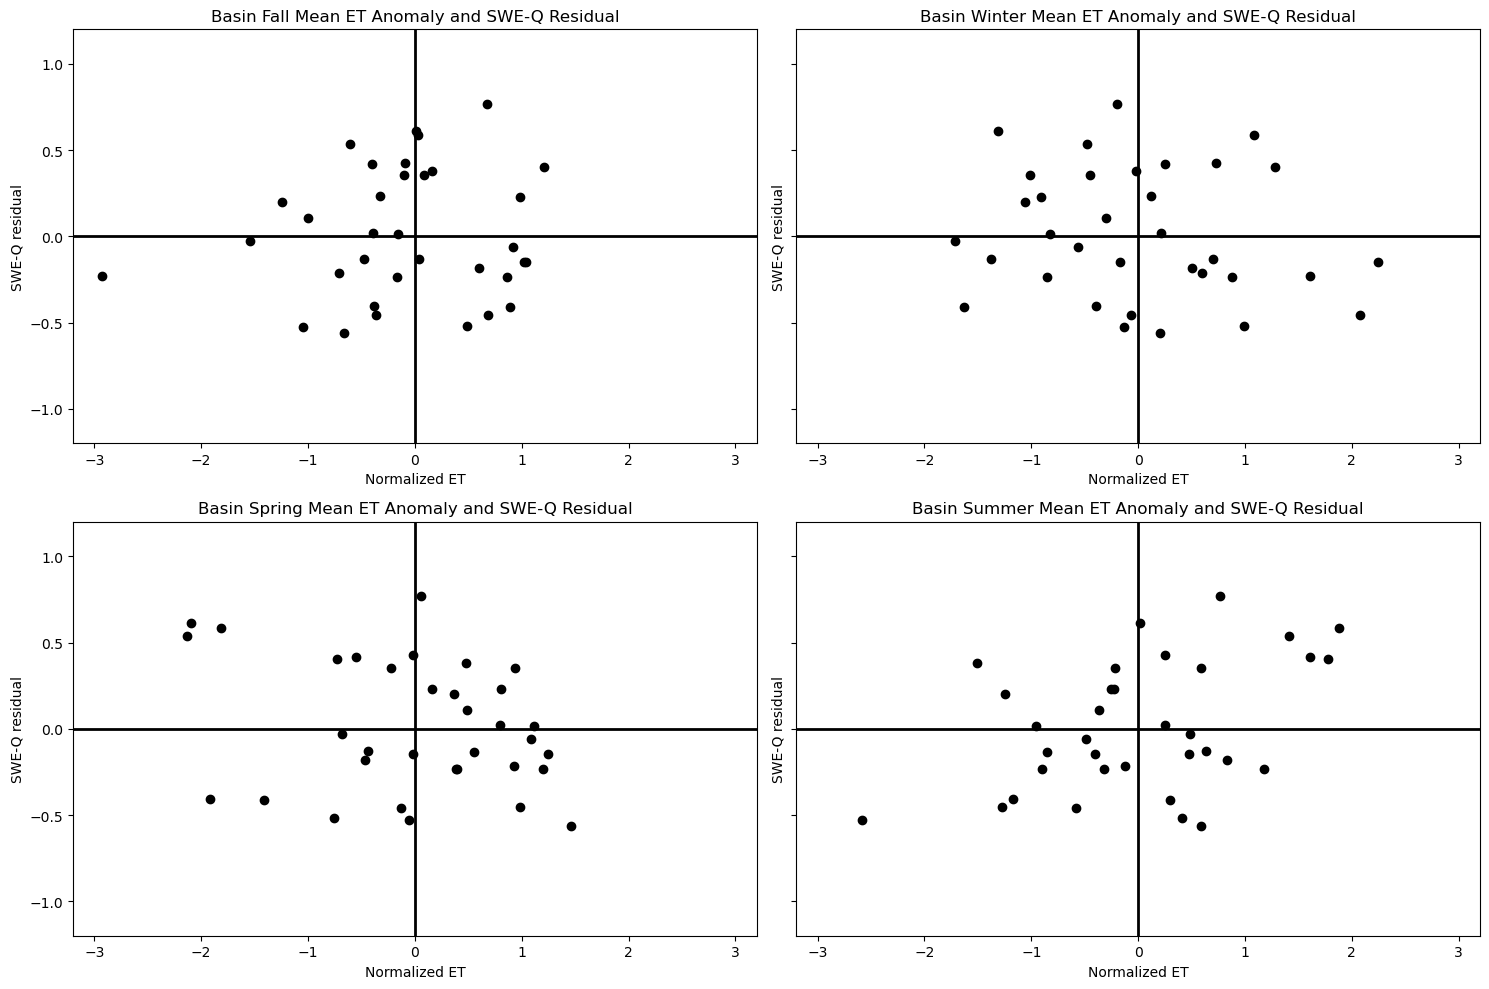

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, sharey=True, figsize=(15,10))

axs = axs.ravel()
seasons = {
    'Fall':norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==11]['ET_rate'].iloc[:-1],
    'Winter':norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==2]['ET_rate'],
    'Spring':norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==5]['ET_rate'],
    'Summer':norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==8]['ET_rate']
}

for i,ax in enumerate(axs):
    season = list(seasons.keys())[i]
    ax.scatter(list(seasons.values())[i],residual.iloc[:-1], color='k')
    ax.set_title(f'Basin {season} Mean ET Anomaly and SWE-Q Residual')
    ax.set_ylabel('SWE-Q residual')
    ax.set_xlabel(f'Normalized ET')
    ax.axhline(0, color='k', lw=2)
    ax.axvline(0, color='k', lw=2)
    ax.set_xlim(-3.2,3.2)
    ax.set_ylim(-1.2,1.2)

### Put the rankings side by side

In [54]:
# Annual ordered SWE-Q residual, Fall soil moisture, Winter ET, Annual ET, Winter Precip, Spring Precip
sorted_year_anomaly_df = pd.DataFrame(
    [
        residual.sort_values().index,
        norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==2].sort_values(by='ET_rate',ascending=False).WY,
        norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==5].sort_values(by='ET_rate',ascending=False).WY,
        sorted_annual_et.index[::-1],
        norm_er_cbrfc_rpj_basin_mean.to_dataframe()['soil_moisture'].sort_values().index,
        sorted_annual_precip.index,
        sorted_spring_precip.sort_values(by='precip').WY,
        sorted_winter_precip.sort_values(by='precip').WY,
        sorted_fall_precip.sort_values(by='precip').WY,
        sorted_summer_precip.sort_values(by='precip').WY,
        sorted_summer_precip.sort_values(by='precip', ascending=False).WY,
        norm_sdd.iloc[1:].sort_values().index,
    ],
).T

cols=['SWE-Q residual', "Fall soil moisture", "Winter ET", "Spring ET","Annual ET","Annual Precip", "Spring Precip", "Winter Precip", "Fall Precip", "Summer Precip", "Monsoon Strength", "SDD"]

sorted_year_anomaly_df = sorted_year_anomaly_df.rename(columns = dict(zip(sorted_year_anomaly_df.columns, cols)))
# sorted_year_anomaly_df = sorted_year_anomaly_df.set_index('SWE-Q residual')


In [55]:
norm_residual = (residual - residual.mean())/residual.std()

In [56]:
east_anomaly_df = pd.DataFrame(
    [
        norm_residual.values,
        norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==2].ET_rate.values,
        norm_anomalies_et_seasonal_df[norm_anomalies_et_seasonal_df.index.month==5].ET_rate.values,
        norm_wrf_annual_et.ET_rate.values,
        norm_er_cbrfc_rpj_basin_mean.to_dataframe()['soil_moisture'].values,
        norm_wrf_annual_precip.precip.values,
        norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==11].precip.values[:-1],
        norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==2].precip.values,
        norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==5].precip.values,
        norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==8].precip.values,
        norm_sdd.values,
        norm_butte_idx_max_df['peak_swe_doy'].values
        
    ]
).T

cols=['SWE-Q residual', "Winter ET", "Spring ET","Annual ET", "Antecedent fall\nsoil moisture","Annual Precip", "Fall Precip", "Winter Precip", "Spring Precip", "Summer Precip", "SDD", "Day of Peak SWE"]

east_anomaly_df = east_anomaly_df.rename(columns = dict(zip(east_anomaly_df.columns, cols)))

east_anomaly_df.set_index(residual.index,inplace=True)

In [65]:
norm_anomalies_precip_seasonal_df.loc[norm_anomalies_precip_seasonal_df.index.month==5].precip.values,


(array([-0.58049259, -0.93029811, -1.4542039 ,  0.56651201,  0.92362758,
        -0.63599651,  1.94074453, -0.43586741,  1.56798595,  0.04158547,
         0.33490188, -0.47331988,  0.18208254, -0.54935909, -0.35155591,
        -1.82283877, -0.05191815, -0.45451139,  0.37296378, -0.64647612,
        -0.23452529, -0.51840878,  0.61330216,  0.03680244,  1.61252649,
        -1.40413361, -0.78152421, -0.15752286,  1.2124607 , -0.70803897,
         0.04347248, -0.12303823,  2.98211467, -0.11705288]),)

Text(0.5, 1.0, 'East River Annual/Seasonal Water Flux Anomalies')

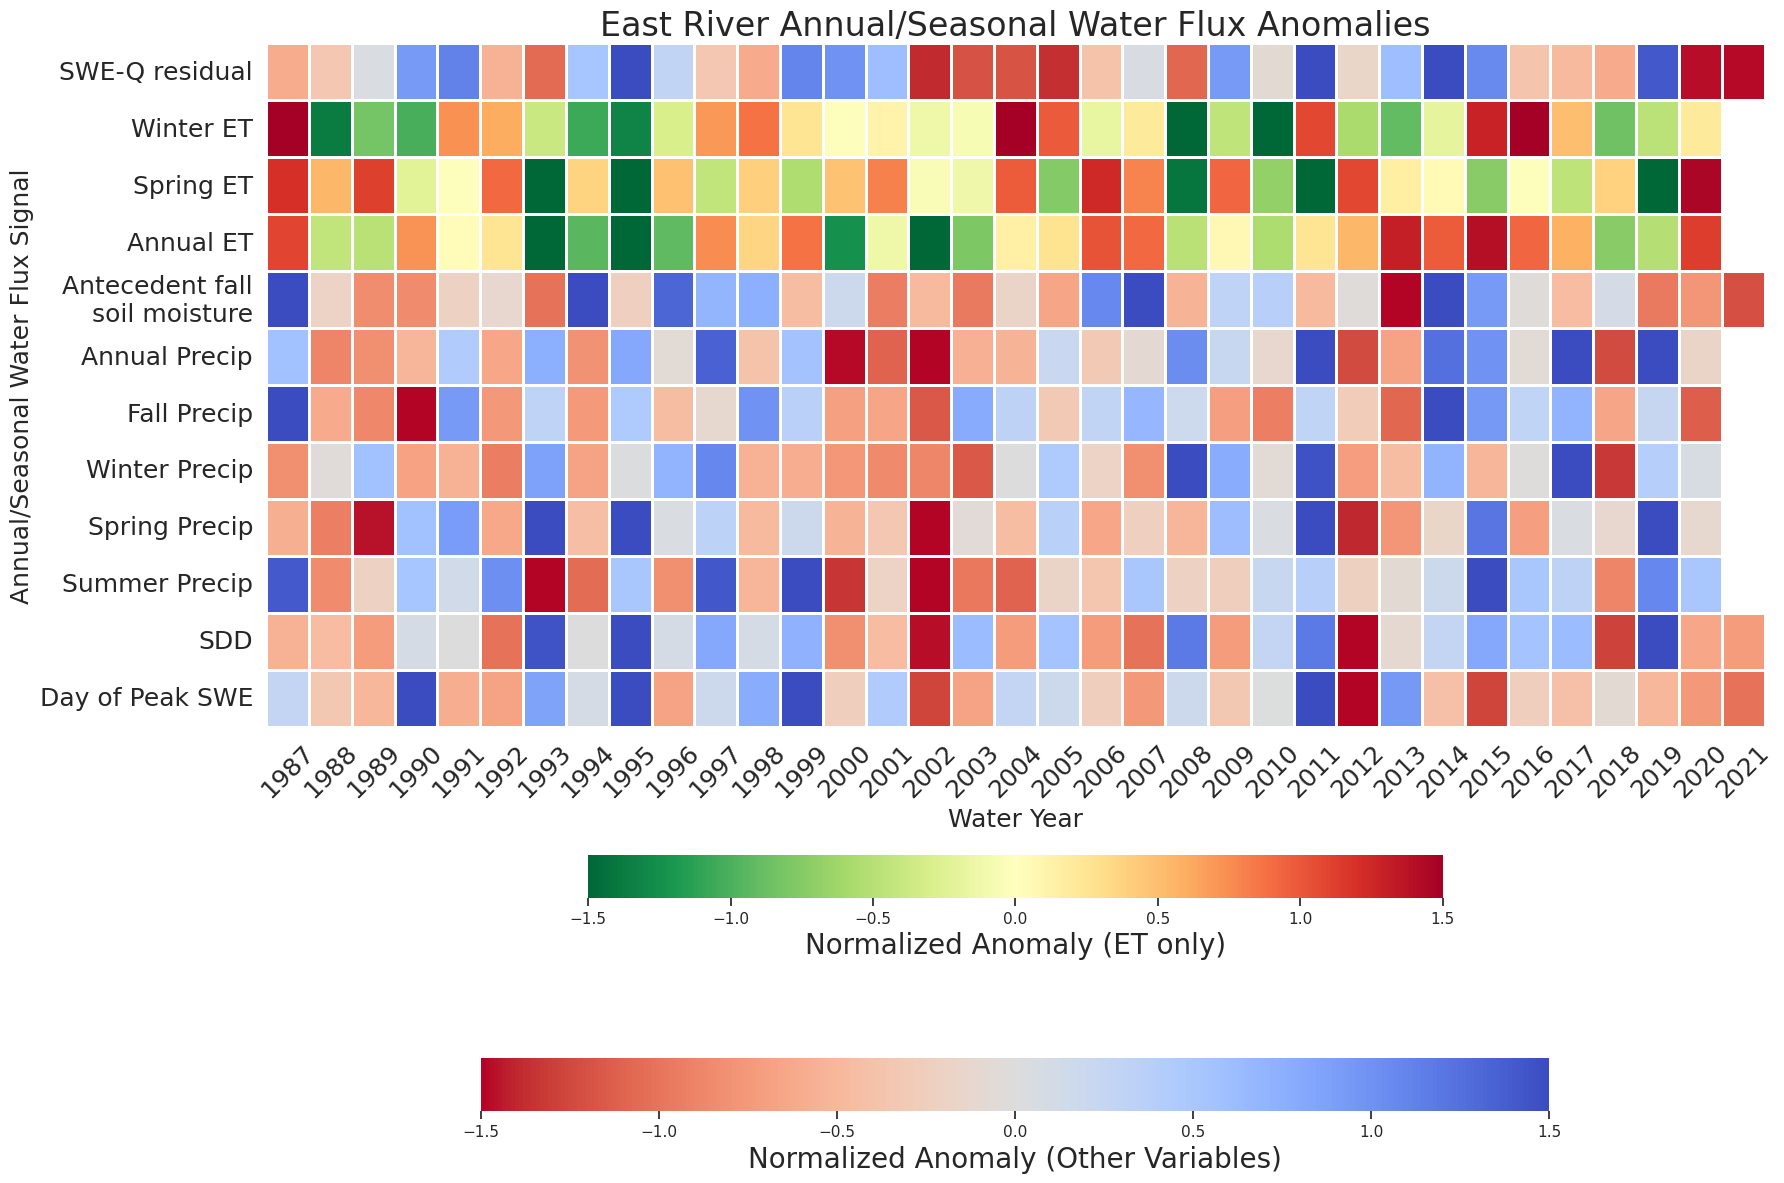

In [70]:
sns.set(font_scale=2)
sns.set_theme(style='white')
fig, ax=plt.subplots(nrows=1,figsize=(18,12), facecolor='w',tight_layout=True)
east_anomaly_T = east_anomaly_df.T

et_specific =east_anomaly_T.copy()
et_specific[~et_specific.index.isin(['Winter ET', 'Spring ET', 'Annual ET'])] = np.nan
sns.heatmap(east_anomaly_T, 
            cmap='coolwarm_r', 
            vmin=-1.5, 
            vmax=1.5,
            linewidths=2, 
            cbar_kws={'label':'Normalized Anomaly (Other Variables)',
                      'orientation':'horizontal',
                      'fraction':.05},
            ax=ax)
ax.figure.axes[-1].xaxis.label.set_size(20)
sns.heatmap(et_specific, 
            cmap='RdYlGn_r', 
            vmin=-1.5, 
            vmax=1.5,
            linewidths=2, 
            cbar_kws={'label':'Normalized Anomaly (ET only)',
                      'orientation':'horizontal',
                      'fraction':.05},
            ax=ax)
ax.figure.axes[-1].xaxis.label.set_size(20)
ax.set_yticklabels(east_anomaly_T.index, rotation=0, ha='right', size=18);
ax.set_xticklabels(east_anomaly_T.columns, rotation=45, ha='center', size=18);
ax.set_ylabel('Annual/Seasonal Water Flux Signal',size=18)
ax.set_xlabel('Water Year', size=18)
ax.set_title('East River Annual/Seasonal Water Flux Anomalies', size=24)

In [63]:
sorted_year_anomaly_df

,SWE-Q residual,Fall soil moisture,Winter ET,Spring ET,Annual ET,Annual Precip,Spring Precip,Winter Precip,Fall Precip,Summer Precip,Monsoon Strength,SDD
0,2021.0,2016.0,2020.0,2015.0,2012.0,2002.0,2002.0,2018.0,1990.0,2002.0,2015.0,2012.0
1,2020.0,2004.0,2006.0,2013.0,2020.0,2000.0,1989.0,2003.0,2002.0,1993.0,1999.0,2002.0
2,2002.0,1987.0,1987.0,2020.0,1992.0,2018.0,2012.0,1992.0,2020.0,2000.0,1997.0,2018.0
3,2005.0,2015.0,1989.0,1987.0,2018.0,2012.0,1988.0,2002.0,2013.0,2004.0,1987.0,1992.0
4,2003.0,2011.0,2012.0,2006.0,2002.0,2001.0,2013.0,2001.0,2010.0,1994.0,2019.0,2007.0
5,2004.0,2005.0,2004.0,2014.0,2000.0,1988.0,2016.0,2007.0,1989.0,2003.0,1992.0,2000.0
6,2008.0,1998.0,2009.0,2016.0,1989.0,1989.0,2006.0,1987.0,1992.0,2018.0,1990.0,2004.0
7,1993.0,1991.0,1992.0,2007.0,1988.0,1994.0,1992.0,2000.0,1994.0,1988.0,1995.0,2009.0
8,1998.0,1997.0,2001.0,1999.0,2019.0,2013.0,1987.0,2012.0,2009.0,1996.0,2007.0,2006.0
9,2018.0,1992.0,2007.0,1997.0,2004.0,1992.0,2000.0,1990.0,2000.0,1998.0,2016.0,2021.0


Notes for the largest negative SWE-Q residual using April 1 SWE - 4/1-9/30 Q over entire East River
1) 2021 - antecedent soil moisture (2018, 2019, 2020)
2) 2020 - antecedent soil moisture (2018, 2019), summer precip anomaly, spring ET anomaly, annual ET anomaly
3) 2002 - annual precip anomaly, winter precip anomaly, fall precip anomaly, summer precip anomaly, early snow disappearance
4) 2005 - winter ET anomaly, spring ET anomaly, early antecedent snow disappearance, antecedent soil moisture
5) 2003 -  antecedent soil moisture, spring precip anonmaly, weak fall precip anomaly
6) 2004 - winter ET anomaly, spring ET anomaly,  weak summer precip anomaly, early sdd
7) 2008 - weak winter ET anomaly, early antecedent snow melt - check SNTL on this year - it had an extremely late start the snow season (2nd latest in last 35 years), warm spring with precip?, weak antecedent fall soil moisture anomaly
8) 1993 -  antecedent soil moisture, fall precip anomaly, antecedent early SDD, somewhat strong monsoon

**Hypothesis (1) - Antecedent fall soil moisture signal leads to the immediate supply of water from snow in spring to replenish this resource, leaving this water in the root zone for plants.**
- Years that would fall in this category: 1993, 2020, 2021, 2005, 2003, 
- Does MERRA-2 also show this? Answer is kind of but not as convincing at the fall soil moisture product

**Hypothesis (2) - Seasonal precipitation anomalies essentially do the same thing, but within a water year, especially if we have a dry winter, spring or fall, more of the melting snow will go towards the supply needed for plants, with snow disappearing earlier**
- Years that would fall in this category: 2018, 2002, 1993, 2020, 2012
- Can I see this in the groundwater data for 2018 (does this year have our lowest groundwater levels?) Yes, we had the lowest groundwater levels during 2018 from the sequence of available data. Showing that drawdown may have been occurring disproportionately

**Hypothesis (3) - ET anomalies during warmer winters/springs remove water from the snowpack that would otherwise flow into the river. Annual ET anomalies may do this year-round with warmer temperatures**
- Years that would fall in this category: 2008, 2020, 2005, 2004, 2003
- Do these years correlate with warmer than average winters/springs? Check out billy's climatology to see if this holds true
- Check out elevational bands of ET and years when the highest band hosts the largest anomalies.

Can I get a signal for 2021 and estimate why we had missing water?
Can I test basin wide water balances with ET, SWE, Precip, Soil Moisture (Merra-2), and streamflow
Q = SWE + P - ET - ΔS

Notes for the largest negative SWE-Q residual using Peak SWE to PEAK Q for my residual

1) 2002 - Spring Precip anomaly, summmer precip anomaly, fall precip anomaly, early date of snow disappearance, annual precip anomaly
2) 2021 - NOTE NO PRECIP OR ET DATA - antecedent fall soil moisture anomaly 2018,2019,2020, early date pf snow disappearance
3) 1993 - Fall soil moisture anomaly and antecedent winter & spring precip anomaly, fall precip anomaly
4) 2018 - Spring (+antecedent) & Fall Precip anomaly, results in fall soil moisute anomaly, early date of snow disappearance, short melt season length, annual precip anomaly,
5) 2020 - soil moisture anomaly in 2018 and 2019, annual ET anomaly
6) 2012 - Winter and Summer Precip anomaly, earliest date of snow disappearance, significant dust on snow year**, annual precip anomaly,
7) 1998 - spring precip anomaly - curious about this one (??)
8) 2013 - Largest winter ET anomaly, large fall soil moisture anomaly, winter precip anomaly, annual ET anomaly, annual precip anomaly

To do:
- check snow water equivalent and streamflow during weird looking years
    these looked okay.
- check springtime SWE/P
- Run the analysis for the Taylor River Basin... do we come to the same conclusions?
- Build a April 1 SWE to Streamflow plot for nearby basins and check if the sorted residuals fall within the same distribution (wilcoxon rank sum test perhaps?)

### Exploring the odd signals by looking at streamflow and SWE for weird years

Text(0, 0.5, 'SWE (cm)')

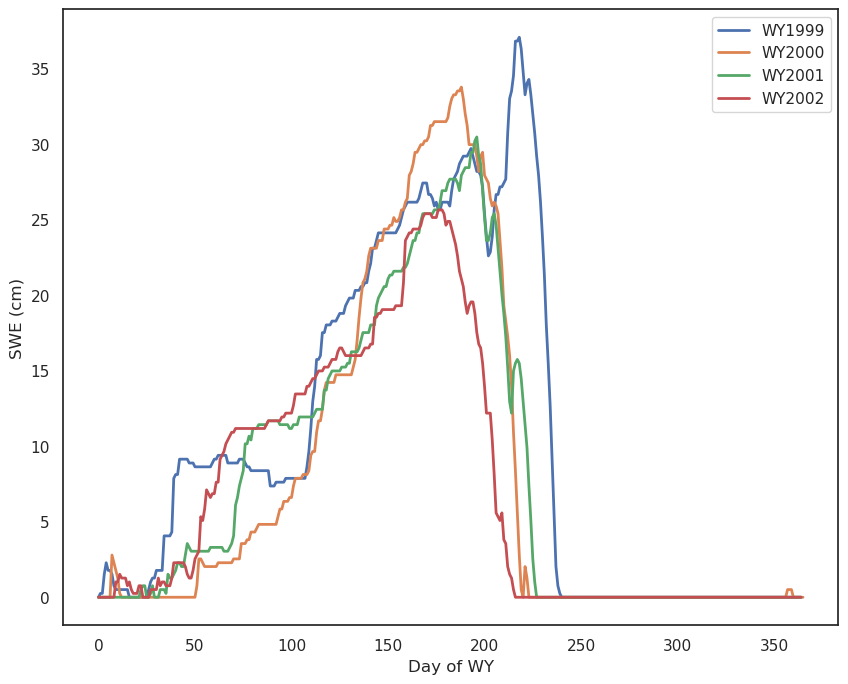

In [64]:
# 2000-2002
# Look at Butte SNTL and Streamflow for 2008
butte_1999 = butte_mean_ds_filtered.where(butte_mean_ds_filtered['WY']==1999).to_dataframe()['WTEQ'].dropna().reset_index()
butte_2000 = butte_mean_ds_filtered.where(butte_mean_ds_filtered['WY']==2000).to_dataframe()['WTEQ'].dropna().reset_index()
butte_2001 = butte_mean_ds_filtered.where(butte_mean_ds_filtered['WY']==2001).to_dataframe()['WTEQ'].dropna().reset_index()
butte_2002 = butte_mean_ds_filtered.where(butte_mean_ds_filtered['WY']==2002).to_dataframe()['WTEQ'].dropna().reset_index()

fig, ax = plt.subplots(figsize=(10,8))

butte_1999['WTEQ'].plot(label='WY1999',ax=ax, lw=2)
butte_2000['WTEQ'].plot(label='WY2000',ax=ax, lw=2)
butte_2001['WTEQ'].plot(label='WY2001',ax=ax, lw=2)
butte_2002['WTEQ'].plot(label='WY2002',ax=ax, lw=2)

ax.legend()
ax.set_xlabel('Day of WY')
ax.set_ylabel('SWE (cm)')

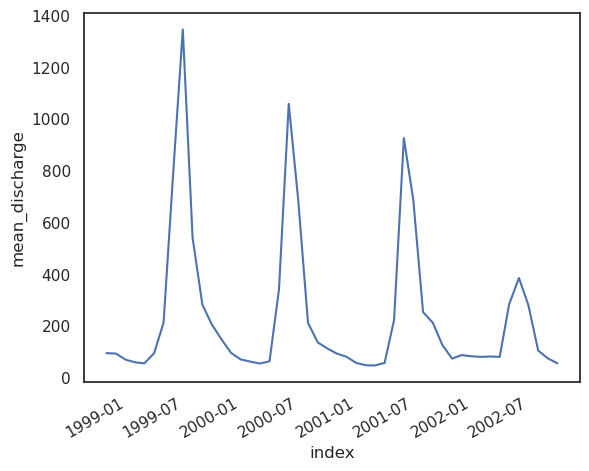

In [65]:
east_river_discharge_almont_monthly_ds.sel(index=slice('1998-10-1','2002-10-1'))['mean_discharge'].plot()